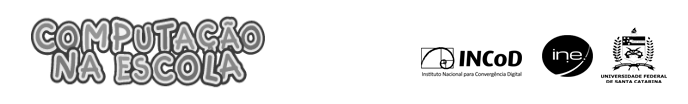

**Visual User Interface for Jupyter - Detecção de objeto**
Desenvolva o seu modelo de machine learning para a detecção de objetos neste ambiente visual de Jupyter Notebook.

O ambiente visual suporta um processo básico de desenvolvimento de um modelo de ML voltado ao ensino de ML no Ensino Médio ou Superior.

A interface visual foi criada pela Iniciativa Computação na Escola/INCoD/INE/UFSC.


## Como usar este notebook

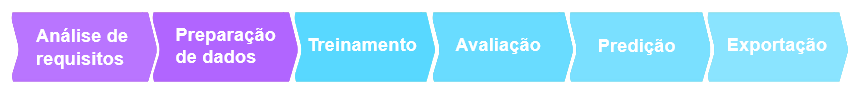

Segue esse processo para desenvolver o seu modelo de detecção de objetos usando [YOLOv5](https://ultralytics.com/yolov5).
Assuma-se que você já coletou as imagens e anotou os objetos usando [Roboflow](https://roboflow.com/).


Para iniciar a interface visual você precisa primeiro rodar a próxima célula para carregar no notebook a interface visual. Uma vez carregado, não será necessário executá-la novamente durante o uso. É normal demorar pois todos os frameworks são importados nesta etapa.

Em seguida, a última célula deve ser executada para dar início a interface visual, assim sendo possível começar o processo de ML. Atualmente em caso de erro ou caso deseje começar de novo você deverá executar essa célula novamente.

In [117]:
#@title Execute esta célula para preparar a interface visual

#Importacao via python da biblioteca fastai
#![ -e /content ] | tee -a >> log.txt && pip install ipywidgets | tee -a >> log.txt && jupyter nbextension enable --py widgetsnbextension | tee -a >> log.txt

#install yolo 5
!git clone https://github.com/ultralytics/yolov5  #| tee -a >> log.txt  # clone repo
%cd yolov5
%pip install -qr requirements.txt

# install yolo 8
from ultralytics import YOLO


#install e import Roboflow
!pip install roboflow
from roboflow import Roboflow


#Path Lib
import os
import yaml
import sys
import shutil
from pathlib import Path
import glob
import re
import cv2

!pip install opencv-python

#Path.ls
from fastai.data import core

#Importações do google colab
from google.colab import drive
from google.colab import widgets as colabwidigets

import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import numpy as np
import cv2
import seaborn as sns

#Pytorch
import torch

#Images
from IPython.display import Image, display, clear_output
import threading

#Importações Ipywidigets
from ipywidgets import widgets as ipywidgets

!pip install pillow


from PIL import Image, ImageColor, ImageDraw, ImageFont
import random

# Install the wget module.
!pip install wget
import wget
import zipfile

from IPython.utils import io

"""with zipfile.ZipFile(wget.download("https://fonts.google.com/download?family=Roboto","roboto.zip"), 'r') as zip_ref:
    zip_ref.extract("Roboto-Regular.ttf")"""

#Download and set font to Arial
wget.download("https://ultralytics.com/assets/Arial.ttf")
font = ImageFont.truetype("Arial.ttf", 40)

class Vector2:
  x:float
  y:float

class LabelData:
  class_id: int
  class_name: str

  color: tuple

  pos: Vector2
  size: Vector2

  def __init__(self, data:str):
    data = data.split(" ")
    self.class_id = int(data[0])

    self.pos = Vector2()
    self.pos.x = float(data[1])
    self.pos.y = float(data[2])

    self.size = Vector2()
    self.size.x = float(data[3])
    self.size.y = float(data[4])

  def draw_label(self, image:Image.Image, draw):
    self.pos.x *= image.width
    self.pos.y *= image.height

    self.size.x *= image.width
    self.size.y *= image.height

    x1 = int(self.pos.x - self.size.x*0.5)
    y1 = int(self.pos.y - self.size.y*0.5)

    x2 = int(self.pos.x + self.size.x*0.5)
    y2 = int(self.pos.y + self.size.y*0.5)

    #Draw bounding box
    draw.rectangle([x1,y1, x2,y2], outline=self.color, width=3)
    #Draw label box
    # get text size
    text_size = font.getsize(self.class_name)
    draw.rectangle([x1,y1-41, x1+text_size[0], y1-41+text_size[1]], fill=self.color)
    draw.text([x1,y1-41], self.class_name, fill='white', font=font)


class m_Header():
  def __init__(self, header, step):
    href = 'https://github.com/joaopedsa/TCC/blob/master/' + step + '.md'
    html = '<p style=font-family:Arial><b>' + header + '<b/> <a target="_blank" href={}> ?</a> <p>'.format(href)
    self.header = ipywidgets.HTML(html)


#setting format of status msgs
class m_Ret():
  def __init__(self, txt, flag):
    if flag == 1:
      self.txt = ipywidgets.HTML(value='<p style="text-align: left;style=font-family:Arial"><span style="color: #339966;">' + txt + '</span></p>')
    if flag == 2:
      self.txt = ipywidgets.HTML(value='<p style="text-align: left;style=font-family:Arial"><span style="color: #ff0000;">' + txt + '</span></p>')

# Global object to hold drive connection details
class DriveConnection:
    root_dir = None

# Instantiate the global object
drive_connection = DriveConnection()

# Função para a conexão com o GDrive
def drive_connect():
  drive.mount('/content/drive', force_remount=True)
  drive_connection.root_dir = "/content/drive/My Drive/"  # Update the root directory here
  return True

# Função para upload de imagens do Roboflow
def parse_roboflow_snippet(snippet:str) -> str:
  snippet = snippet.replace("!pip install roboflow\n\nfrom roboflow import Roboflow\n","global dataset\n")
  return snippet

# Função para extrair project das imagens carregadas do Roboflow
"""def get_snippet_project_roboflow(snippet:str) -> str:
    return snippet.split('.project("')[1].split('")')[0]"""

# Função para extrair metricas do output do treinamento--precisa ser ainda melhorada colocando os valores em um panda
def get_training_metrics() -> str:
    try:
        with open('/content/yolov5/training_output.txt', "r") as train_output:
            text = train_output.read()
            parts = text.split('Fusing layers...')
            if len(parts) > 1:
                return parts[1]  # Return the part of the text after 'Fusing layers...'
            else:
                return "Training metrics not found. Please check the training output for details."
    except Exception as e:
        return f"An error occurred while reading training metrics: {e}"

# Atributos do Dataset
os.environ["DATASET_DIRECTORY"] = ""
os.environ["CONFIG_YAML"] = ""
dataset_total_images = 0
dataset_dict_labels = {}

# Layouts e Styles
l_txt = ipywidgets.Layout(width='66%')
l_btn = ipywidgets.Layout(width='40%')
l_vbox = ipywidgets.Layout(width='720px')
l_hbox = ipywidgets.Layout(width='90%')
l_req = ipywidgets.Layout(width='95%', height='90px')
l_codesnippet = ipywidgets.Layout(width='66%', height='120px')
l_hidden_red = ipywidgets.Layout(width='90%', visibility = 'hidden')
l_hidden_tra = ipywidgets.Layout(width='90%', visibility = 'hidden')
l_btn_hbox = ipywidgets.Layout(flex_flow='column',align_items='center')
s_desc_wid = {'description_width':'25%'}

# Modelos do yolov5
models = ['yolov5n', 'yolov5s', 'yolov5m', 'yolov5l', 'yolov5x']

# Lista de tipos para exportar
export_list = ['pt', 'onnx', 'tflite', 'torchscript', 'pb']



#Function to count quantidades de imagens por categoria. Retorna número total de imagens e dict ({'capivara': 16, 'jacare': 7})
def total_by_category_roboflow():
    total_images = 0
    categories = {}

    # Load categories from YAML using a proper YAML loader
    with open(os.environ["CONFIG_YAML"], "r") as yaml_file:
        data = yaml.safe_load(yaml_file)
        category_names = [item for item in data.get('names', [])]  # Adjust 'names' based on your YAML structure

    # Validate if any categories are loaded
    if not category_names:
        raise ValueError("No categories found in the YAML configuration.")

    # Process each label file
    path = os.environ["DATASET_DIRECTORY"]
    for folder in os.listdir(path):
        labels_path = os.path.join(path, folder, "labels")
        if os.path.exists(labels_path):
            for label_file in os.listdir(labels_path):
                label_file_path = os.path.join(labels_path, label_file)
                with open(label_file_path, "r") as file:
                    for line in file:
                        parts = line.strip().split()
                        if parts:
                            category_index = int(parts[0])
                            if 0 <= category_index < len(category_names):
                                category = category_names[category_index]
                                categories[category] = categories.get(category, 0) + 1
                                total_images += 1
                            else:
                                raise IndexError(f"Category index {category_index} out of range.")

    return total_images, categories


def generate_images_preview():
  path = os.environ["DATASET_DIRECTORY"]
  category_names =  []
  with open(os.environ["CONFIG_YAML"], "r") as yaml_config:
    for line in yaml_config.readlines():
      if line.startswith("- "):
        category_names.append(line.replace("- ", "").replace("\n",""))

  trainlabels_path = path + "/train/labels/"
  trainimages_path = path + "/train/images/"

  #font = ImageFont.truetype(size=50)

  category_colors = []

  for i in category_names:
    clr = (random.randint(100,255),random.randint(100,255),random.randint(100,255))
    category_colors.append(clr)

  images = []
  for label_file in os.listdir(trainlabels_path):
    label_path = trainlabels_path + label_file
    image_path = trainimages_path + label_file.replace(".txt",".jpg")

    try:
        # Attempt to open the image file
        img = Image.open(image_path)
    except (FileNotFoundError, PIL.UnidentifiedImageError) as e:
        # Handle exceptions if the file is not found or if it's not a valid image
        print(f"Error opening image file: {image_path}")
        print(f"Exception: {e}")
        # You might want to skip this image or handle it differently
        return None

    draw = ImageDraw.Draw(img)

    with open(label_path) as file:
      for line in file.readlines():
        label_data = LabelData(line)
        label_data.class_name = category_names[label_data.class_id]
        label_data.color = category_colors[label_data.class_id]
        label_data.draw_label(img, draw)


    images.append(img)

  return images



def render_categories(total_images, category_dict):
    # Set seaborn theme
    sns.set_theme(style="darkgrid")

    # Get data as lists from the category_dict {'capivara': 16, 'jacare': 7}
    categories = list(category_dict.keys())
    # Capitalize the first letter of each category
    categories = [category.capitalize() for category in categories]
    counts = list(category_dict.values())

    # Initialize the matplotlib figure, setting the size of the figure depending on the number of categories
    fig, ax = plt.subplots(figsize=(5, (len(category_dict) * 0.6)))

    # Set color palette
    custom_palette = sns.color_palette("Paired", n_colors=len(categories))

    # Plot the diagram
    ax = sns.barplot(x=counts, y=categories, palette=custom_palette, hue=categories, legend=False)

    # Set axis labels
    ax.set_ylabel('Categorias')
    ax.set_xlabel('Quantidade de imagens')
    ax.set_title('Quantidade total de imagens: ' + str(total_images), loc='left', fontweight="bold")

    # Show the plot
    plt.show()


# Função que renderiza a janela de Analise De Requisitos
def render_analise_de_requisitos(tab):
  with tab.output_to(0, select=True):
    grid0 = colabwidigets.Grid(1, 1)
    with grid0.output_to(0,0):

      lbl_cat = ipywidgets.Label(value = "Categorias")
      txta_cat1 = ipywidgets.Textarea(value='',placeholder='Descrição das categorias de objetos que devem ser detectados \nex. 10 categorias de objetos encontrados dentro de casa, que podem interferir no dia a dia de uma pessoa com deficiência visual: Armário, Cachorro, Cadeira, Cama, Criado Mudo, Mesa, Mochila, Porta, Sapato e Sofá',disabled=False,layout=l_req)

      lbl_fontededados = ipywidgets.Label(value = "Fonte de dados")
      txta_fontededados = ipywidgets.Textarea(value='',placeholder='ex. imagens coletadas pelos criadores do modelo',disabled=False,layout=l_req)

      lbl_qtddedados = ipywidgets.Label(value = "Quantidade de dados")
      txta_qtddedados = ipywidgets.Textarea(value='',placeholder='ex. No mínimo 30 exemplares para cada categoria',disabled=False,layout=l_req)

      lbl_pdr_img = ipywidgets.Label(value = "Padronização das imagens")
      txta_pdr_img1 = ipywidgets.Textarea(value='',placeholder='Descrição do formato das imagens \nex. Formato: .jpg, Tamanho: 640x640 pixels',disabled=False,layout=l_req)

      lbl_rotulacao = ipywidgets.Label(value = "Rotulação dos dados")
      txta_rotulacao = ipywidgets.Textarea(value='',placeholder='Descreve por quem e como foram as anotações das imagens \nex. Por estudantes de curso de computação no ensino superior e rotulados na ferramenta roboflow',disabled=False,layout=l_req)

      lbl_desempenho = ipywidgets.Label(value = "Desempenho esperado")
      txta_desempenho = ipywidgets.Textarea(value='',placeholder='Especifique o desempenho esperado (usando uma ou mais medidas (mAP 0.5, mAP 0.95, precision, recall, F1 score) \nex. mAP0.5 ou 0.95: no mínimo 75%, Precision: no minimo 75%, Recall: no minimo 75%...',disabled=False,layout=l_req)

      itens_req = ipywidgets.VBox([ ipywidgets.VBox([lbl_cat, txta_cat1], layout=l_hbox),
                                    ipywidgets.VBox([lbl_fontededados, txta_fontededados], layout=l_hbox),
                                    ipywidgets.VBox([lbl_qtddedados, txta_qtddedados], layout=l_hbox),
                                    ipywidgets.VBox([lbl_pdr_img, txta_pdr_img1], layout=l_hbox),
                                    ipywidgets.VBox([lbl_rotulacao, txta_rotulacao], layout=l_hbox),
                                    ipywidgets.VBox([lbl_desempenho, txta_desempenho], layout=l_hbox)],layout=l_vbox)

      display(itens_req)

# Função que renderiza a janela para preparação dos dados
def render_preparacao_dos_dados(tab):
    with tab.output_to(1, select=False):
        grid1 = colabwidigets.Grid(6,1)

        # Create a tab widget for File Directory and Roboflow Snippet
        sub_tabs = ipywidgets.Tab()
        file_directory_tab = ipywidgets.VBox()
        roboflow_snippet_tab = ipywidgets.VBox()

        # Renderização da tab de importação dos dados via Google Drive
        with grid1.output_to(1,0):
            lbl_path = m_Header('Caminho do seu conjunto de dados', 'PREPARACAO_DOS_DADOS')
            input_path = ipywidgets.Text(placeholder='Insira o caminho do seu conjunto de dados ex: /mask-dataset', value='', layout=l_txt)
            btn_path = ipywidgets.Button(description='Carregar caminho', layout=l_btn, button_style='info', button_color='#58d8ff', disabled=True)
            hbox_path = ipywidgets.HBox([input_path, btn_path], layout=l_hbox)
            vbox_path = ipywidgets.VBox([lbl_path.header, hbox_path], layout=l_vbox)
            file_directory_tab.children = [vbox_path]

            # Check input and enable button
            def check_input_path(_):
                btn_path.disabled = not input_path.value.strip()

            input_path.observe(check_input_path, names='value')

            def on_btn_path_clicked(a):
                with grid1.output_to(1,0):
                    grid1.clear_cell()
                    # Make sure to strip any leading/trailing whitespace and ensure it formats correctly
                    user_input = input_path.value.strip()
                    # Concatenate with the root directory
                    dataset_directory = os.path.join(drive_connection.root_dir, user_input)

                    print(f"Checking directory: {dataset_directory}")  # Debugging output
                    # Set the environment variable to the fully resolved directory path
                    os.environ["DATASET_DIRECTORY"] = dataset_directory

                    # Now check if the directory exists
                    if Path(dataset_directory).is_dir():
                        msg_ret = m_Ret(f'Path: {dataset_directory} definido com sucesso', 1)
                        create_config_files()  # Ensure this function is implemented
                    else:
                        msg_ret = m_Ret(f'Path: {dataset_directory} não encontrado', 2)

                    display(msg_ret.txt)

            btn_path.on_click(on_btn_path_clicked)

        # Renderização da tab de importação dos dados via Roboflow
        with grid1.output_to(0,0):
            lbl_path = m_Header('Code snippet', 'PREPARACAO_DOS_DADOS')
            input_snippet = ipywidgets.Textarea(placeholder='Insira o code snippet exportado do Roboflow', value='', layout=l_codesnippet)
            btn_snippet = ipywidgets.Button(description='Carregar imagens', layout=l_btn, button_style='info', button_color='#58d8ff', disabled=True)
            hbox_snippet = ipywidgets.HBox([input_snippet, btn_snippet], layout=l_hbox)
            vbox_snippet = ipywidgets.VBox([lbl_path.header, hbox_snippet], layout=l_vbox)
            roboflow_snippet_tab.children = [vbox_snippet]

            # Check input and enable button
            def check_input_snippet(_):
                btn_snippet.disabled = not input_snippet.value.strip()

            input_snippet.observe(check_input_snippet, names='value')

            def on_btn_snippet_clicked(a):
                with grid1.output_to(1,0):
                    grid1.clear_cell()
                    with io.capture_output() as captured:
                        rf = Roboflow()
                        global dataset
                        try:
                            exec(parse_roboflow_snippet(input_snippet.value))
                        except Exception as e:
                            msg_ret = m_Ret(f"Erro ao carregar o conjunto de dados: {str(e)}", 2)
                            display(msg_ret.txt)
                    os.environ["DATASET_DIRECTORY"] = dataset.location
                    os.environ["CONFIG_YAML"] = dataset.location + '/data.yaml'
                    if Path(os.environ["DATASET_DIRECTORY"]).is_dir():
                        msg_ret = m_Ret('Conjunto de dados carregado com sucesso', 1)
                    else:
                        msg_ret = m_Ret('Erro no carregamento do conjunto de dados', 2)
                    display(msg_ret.txt)

            btn_snippet.on_click(on_btn_snippet_clicked)


        # Assign tabs
        sub_tabs.children = [file_directory_tab, roboflow_snippet_tab]
        sub_tabs.set_title(0, 'Caminho do Conjunto de Dados')
        sub_tabs.set_title(1, 'Snippet do Roboflow')

         # Place the sub_tabs in the grid
        with grid1.output_to(0, 0):
            display(sub_tabs)

        # Additional activities for dataset information and image preview
        render_dataset_info_and_preview(grid1)

# Function to handle dataset information and image preview
def render_dataset_info_and_preview(grid1):
    # Atividade - Visualizar infos do dataset
    with grid1.output_to(2, 0):
        lbl_dataset_info = ipywidgets.Label(value = "Informações do conjunto de dados")
        btn_view_total_by_category = ipywidgets.Button(description='Mostrar', layout=l_btn, button_style='info', button_color='#58d8ff')
        hbox_dataset_info = [lbl_dataset_info, ipywidgets.Box([btn_view_total_by_category], layout=l_btn_hbox)]
        vbox_dataset_info = ipywidgets.VBox(hbox_dataset_info, layout=l_vbox)
        display(vbox_dataset_info)

        def on_btn_view_total_by_category(_):
            with grid1.output_to(3, 0):
                grid1.clear_cell()
                dataset_total_images, dataset_dict_labels = total_by_category_roboflow()
                render_categories(dataset_total_images, dataset_dict_labels)

        btn_view_total_by_category.on_click(on_btn_view_total_by_category)

    # Atividade - Visualizar exemplos do conjunto de dados
    with grid1.output_to(4, 0):
      lbl_img_preview = ipywidgets.Label(value = "Visualizar exemplos do conjunto de dados")

      btn_img_preview = ipywidgets.Button(description='Mostrar', layout=l_btn, button_style='info', button_color = '#58d8ff')
      hbox_img_preview = [lbl_img_preview, ipywidgets.Box([btn_img_preview], layout=l_btn_hbox)]
      vbox_img_preview = ipywidgets.VBox(hbox_img_preview, layout=l_vbox)
      display(vbox_img_preview)

      def on_btn_img_preview(_):
        with grid1.output_to(5,0):
          grid1.clear_cell()
          images = generate_images_preview()
          images_widgets = []
          iter = 0

          for i in range(min(9,len(images))):
            image_preview = images[i]
            image_preview.save(str(iter)+".tmp.jpg")
            with open(str(iter)+".tmp.jpg", "rb") as file:
              results_image_widget = ipywidgets.Image(
                  value=file.read(),
                  format='png',
                  width=240,
                  height=240,
              )
            images_widgets.append(results_image_widget)
          grid = ipywidgets.GridBox(images_widgets, layout=ipywidgets.Layout(grid_template_columns="repeat(3, 240px)"))
          display(grid)


      btn_img_preview.on_click(on_btn_img_preview)

# Função que renderiza a janela para o treinamento
def render_treinamento(tab):
    with tab.output_to(2, select=False):
        grid2 = colabwidigets.Grid(2, 1)
        with grid2.output_to(0, 0):
            lbl_trainning = m_Header('Treinamento do modelo', 'TREINAMENTO')

            # Updated model dropdown to include YOLOv5 and YOLOv8 options
            model = ipywidgets.Dropdown(
                options=['yolov5', 'yolov8'],  # Model options
                value='yolov5',  # Default selection
                description='Modelo',
                disabled=False,
            )

            slider_batches = ipywidgets.IntSlider(min=1,
                                                  max=128,
                                                  step=1,
                                                  value=16,
                                                  description_tooltip='numero de lotes',
                                                  description='Tamaho do batch',
                                                  layout=l_hbox,
                                                  style=s_desc_wid)

            slider_image_size = ipywidgets.IntSlider(min=64,
                                                     max=1280,
                                                     step=64,
                                                     value=640,
                                                     description_tooltip='tamanho das imagens',
                                                     description='Tamanho das imagens',
                                                     layout=l_hbox,
                                                     style=s_desc_wid)

            slider_epochs = ipywidgets.IntSlider(min=1,
                                                 max=500,
                                                 step=1,
                                                 value=50,
                                                 description_tooltip='número de épocas',
                                                 description='Quantidade de épocas',
                                                 layout=l_hbox,
                                                 style=s_desc_wid)

            # Adding a slider for learning rate
            slider_learning_rate = ipywidgets.FloatSlider(min=0.0001,
                                                          max=0.01,
                                                          step=0.0001,
                                                          value=0.001,
                                                          description_tooltip='taxa de aprendizado',
                                                          description='Taxa de aprendizado',
                                                          layout=l_hbox,
                                                          style=s_desc_wid)

            btn_train_model = ipywidgets.Button(description='Treinar Modelo', tooltip='', layout=l_btn, button_style='info', button_color='#58d8ff')

            hbox_trainning = [lbl_trainning.header, model, slider_batches, slider_image_size, slider_epochs, slider_learning_rate, ipywidgets.Box([btn_train_model], layout=l_btn_hbox)]
            vbox_trainning = ipywidgets.VBox(hbox_trainning, layout=l_vbox)
            display(vbox_trainning)

            def on_btn_train_model_clicked(b):
              with grid2.output_to(1, 0):
                  grid2.clear_cell()
                  # Set environment variables from sliders
                  os.environ["BATCHES"] = str(slider_batches.value)
                  os.environ["IMAGE_SIZE"] = str(slider_image_size.value)
                  os.environ["EPOCHS"] = str(slider_epochs.value)
                  os.environ["LEARNING_RATE"] = str(slider_learning_rate.value)
                  os.environ["MODEL"] = str(model.value)

                  # Removing previous training runs if they exist
                  if os.path.isdir("/content/yolov5/runs"):
                      shutil.rmtree("/content/yolov5/runs")

                  try:
                      # Capturing the output of the training process
                      with open('/content/yolov5/training_output.txt', 'w') as f:
                          sys.stdout = f

                          # Determine which model to train based on selection
                          if model.value == 'yolov5':
                              # Training YOLOv5
                              !python /content/yolov5/train.py --img ${IMAGE_SIZE} --batch ${BATCHES} --epochs ${EPOCHS} --data ${CONFIG_YAML} --weights yolov5/${MODEL}.pt --lr ${LEARNING_RATE}
                          elif model.value == 'yolov8':
                              # Training YOLOv8
                              !yolo task=detect mode=train model=yolov8n.pt data=${CONFIG_YAML} epochs=${EPOCHS} imgsz=${IMAGE_SIZE} batch=${BATCHES} lr0=${LEARNING_RATE}

                  finally:
                      sys.stdout = sys.__stdout__  # Restore stdout

                  # Create user-friendly output: parse and display metrics
                  display(get_training_metrics())

            btn_train_model.on_click(on_btn_train_model_clicked)

# Render Avaliação
def render_avaliacao(tab):
  with tab.output_to(3, select=False):
    grid6 = colabwidigets.Grid(8,1)

    with grid6.output_to(0,0):
      lbl_treinamento = ipywidgets.Label(value='Avaliação do treinamento')
      btn_treinamento = ipywidgets.Button(description='Mostrar', layout=l_btn, style=s_desc_wid, button_style='info', button_color = '#58d8ff')

      box_predict = ipywidgets.VBox([lbl_treinamento, ipywidgets.HBox([btn_treinamento], layout=l_btn_hbox)], layout=l_vbox)
      display(box_predict)

      def on_btn_treinamento(b):
        with grid6.output_to(1,0):
          grid6.clear_cell()
          results = open("/content/yolov5/runs/train/exp/results.png", "rb")
          results_image = results.read()
          results_image_widget = ipywidgets.Image(
              value=results_image,
              format='png',
              width=720,
              height=720,
          )
          display(results_image_widget)

      btn_treinamento.on_click(on_btn_treinamento)

    with grid6.output_to(2,0):
      lbl_desempenho = ipywidgets.Label(value='Avaliação do desempenho')
      btn_desempenho = ipywidgets.Button(description='Mostrar', layout=l_btn, style=s_desc_wid, button_style='info', button_color = '#58d8ff')

      box_predict = ipywidgets.VBox([lbl_desempenho, ipywidgets.HBox([btn_desempenho], layout=l_btn_hbox)], layout=l_vbox)
      display(box_predict)

      def on_btn_desempenho(b):
        with grid6.output_to(3,0):
          grid6.clear_cell()
          #verificar se já existe um diretório com os resultados de uma validação anterior, se for, deletar o diretório runs/val
          if os.path.isdir("/content/yolov5/runs/val"):
             shutil.rmtree("/content/yolov5/runs/val")
          #executar validação
          !python /content/yolov5/val.py --data ${CONFIG_YAML} --weights /content/yolov5/runs/train/exp/weights/best.pt

          #getting example batch of validated images
          val_batch_images= Image.open('/content/yolov5/runs/val/exp/val_batch0_pred.jpg')
          #resize the image for display
          newsize = (500, 500)
          val_batch_images = val_batch_images.resize(newsize)
          #display one batch of validated images
          display(val_batch_images)

      btn_desempenho.on_click(on_btn_desempenho)

    with grid6.output_to(4,0):
      lbl_f1 = ipywidgets.Label(value='Curva do F1 Score')
      btn_f1 = ipywidgets.Button(description='Mostrar', layout=l_btn, style=s_desc_wid, button_style='info', button_color = '#58d8ff')

      box_predict = ipywidgets.VBox([lbl_f1, ipywidgets.HBox([btn_f1], layout=l_btn_hbox)], layout=l_vbox)
      display(box_predict)

      def on_btn_f1(b):
        with grid6.output_to(5,0):
          grid6.clear_cell()
          f1_curve = open("/content/yolov5/runs/train/exp/F1_curve.png", "rb")
          f1_curve_image = f1_curve.read()
          f1_curve_image_widget = ipywidgets.Image(
              value=f1_curve_image,
              format='png',
              width=720,
              height=720,
          )
          display(f1_curve_image_widget)

      btn_f1.on_click(on_btn_f1)

    with grid6.output_to(6,0):
      lbl_matrix = ipywidgets.Label(value='Matriz de Confusão')
      btn_matrix = ipywidgets.Button(description='Mostrar', layout=l_btn, style=s_desc_wid, button_style='info', button_color = '#58d8ff')

      box_predict = ipywidgets.VBox([lbl_matrix, ipywidgets.HBox([btn_matrix], layout=l_btn_hbox)], layout=l_vbox)
      display(box_predict)

      def on_btn_confusion_matrix(b):
        with grid6.output_to(7,0):
          grid6.clear_cell()
          confusion_matrix = open("/content/yolov5/runs/train/exp/confusion_matrix.png", "rb")
          confusion_matrix_image = confusion_matrix.read()
          confusion_matrix_image_widget = ipywidgets.Image(
              value=confusion_matrix_image,
              format='png',
              width=720,
              height=720,
          )
          display(confusion_matrix_image_widget)

      btn_matrix.on_click(on_btn_confusion_matrix)
#Predição

#correct test path in yaml created by ROBOFLOW
def correct_yaml_test_path():
  text = ""
  with open(os.environ["CONFIG_YAML"], "r") as file:
      text = file.read()

  test_path = text.split("test: ")[1].split("train: ")[0].replace("\n", "")

  text = text.replace(test_path, os.environ["DATASET_DIRECTORY"].replace("/content/yolov5/","") + "/test/images")
  with open(os.environ["CONFIG_YAML"], "w") as file:
     file.write(text)

# Render Predição
def render_predicao(tab):
  with tab.output_to(4, select=False):
    grid6 = colabwidigets.Grid(5,1)
    slider_confidence = ipywidgets.IntSlider(min = 1,
                                            max = 100,
                                            step = 1,
                                            value = 10,
                                            description_tooltip='Taxa de Confiança',
                                            description='Confiança',
                                            layout=l_hbox,
                                            style=s_desc_wid)

    with grid6.output_to(0,0):
      lbl_confidence = m_Header('Taxa de Confiança', 'PREDICAO')

      box_confidence = ipywidgets.VBox([lbl_confidence.header, slider_confidence], layout=l_vbox)
      display(box_confidence)

    with grid6.output_to(1,0):
      lbl_prediction = ipywidgets.Label(value="Teste com o conjunto de teste")

      btn_pred = ipywidgets.Button(description='Teste', layout=l_btn, style=s_desc_wid, button_style='info', button_color = '#58d8ff')
      box_predict = ipywidgets.VBox([lbl_prediction, ipywidgets.HBox([btn_pred], layout=l_btn_hbox)], layout=l_vbox)
      display(box_predict)

      def on_btn_pred(b):
        with grid6.output_to(2,0):
          grid6.clear_cell()
          #verificar se já existe um diretório com os resultados de uma validação anterior, se for, deletar o diretório runs/val
          if os.path.isdir("/content/yolov5/runs/val"):
             shutil.rmtree("/content/yolov5/runs/val")

          os.environ["CONFIDENCE"] = str(slider_confidence.value/100)
          #corrigir o test path no data.yaml criado pelo ROBOFLOW
          correct_yaml_test_path()
          #!python /content/yolov5/detect.py --weights /content/yolov5/runs/train/exp/weights/best.pt --img ${IMAGE_SIZE} --conf ${CONFIDENCE} --source ${DATASET_DIRECTORY}/test/images/
          !python /content/yolov5/val.py --task 'test' --weights /content/yolov5/runs/train/exp/weights/best.pt --imgsz ${IMAGE_SIZE}  --data ${CONFIG_YAML} --conf-thres=${CONFIDENCE}

          images_widgets = []
          """for imageName in glob.glob('/content/yolov5/runs/val/exp/*.jpg'):
            results = open(imageName, "rb")
            results_image = results.read()
            results_image_widget = ipywidgets.Image(
                value=results_image,
                format='png',
                width=320,
                height=320,
            )
            images_widgets.append(results_image_widget)
          grid = ipywidgets.GridBox(images_widgets, layout=ipywidgets.Layout(grid_template_columns="repeat(3, 320px)"))
          display(grid)
          for imageName in glob.glob('/content/yolov5/runs/val/exp/val_batch0_pred.jpg'):
            display(Image.open(imageName), width=320, height=320)"""
          #getting example predicted images
          val_batch_images= Image.open('/content/yolov5/runs/val/exp/val_batch0_pred.jpg')
          #resize the image for display
          newsize = (500, 500)
          val_batch_images = val_batch_images.resize(newsize)
          display(val_batch_images)

      btn_pred.on_click(on_btn_pred)

    with grid6.output_to(3,0):
      lbl_prediction_upload = ipywidgets.Label(value="Predição pelo upload de uma imagem")

      btn_upload = ipywidgets.FileUpload(button_style='info', button_color = '#58d8ff')
      btn_pred = ipywidgets.Button(description='Predição', layout=l_btn, style=s_desc_wid, button_style='info', button_color = '#58d8ff')
      box_predict = ipywidgets.VBox([lbl_prediction_upload, ipywidgets.HBox([btn_upload, btn_pred], layout=l_btn_hbox)], layout=l_vbox)
      display(box_predict)

      os.environ["PREDICT_DIR"] = "/content/yolov5/predict/"

      def on_btn_pred(b):
        if not Path("/content/yolov5/predict/").is_dir():
          !mkdir /content/yolov5/predict

        for index in range(len(btn_upload.data)):
          with open(os.environ["PREDICT_DIR"] + "predict" + str(index) + ".jpg" , "w+b") as i:
              i.write(btn_upload.data[index])

        with grid6.output_to(4,0):
          grid6.clear_cell()
          if Path("/content/yolov5/runs/detect").is_dir():
            !rm -rf /content/yolov5/runs/detect

          os.environ["CONFIDENCE"] = str(slider_confidence.value/100)
          !python /content/yolov5/detect.py --weights /content/yolov5/runs/train/exp/weights/best.pt --img ${IMAGE_SIZE} --conf ${CONFIDENCE} --source ${PREDICT_DIR}

          """for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'):
            display(Image.open(imageName), width=320, height=320)
            print("\n")"""
          #getting predicted image
          for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'):
            predicted_image = Image.open(imageName)
          #resize the image for display
          newsize = (320, 320)
          predicted_image = predicted_image.resize(newsize)
          display(predicted_image)

      btn_pred.on_click(on_btn_pred)

# Render Exportação
def render_exportacao(tab):
  with tab.output_to(5, select=False):
    grid7 = colabwidigets.Grid(3,1)
    with grid7.output_to(0,0):
      lbl_export = m_Header('Exportação do modelo', 'EXPORTACAO')
      lbl_model = ipywidgets.Label(value = "Formato")
      lbl_path = ipywidgets.Label(value = "Caminho para exportação do modelo treinado")

      model_export = ipywidgets.Dropdown(
          options=export_list,
          value=export_list[0],
          disabled=False,
      )
      export_path = ipywidgets.Text(placeholder='Insira um caminho XXX de um diretório válido no drive: /content/drive/my-drive/XXX',value='',layout=l_txt)
      btn_export = ipywidgets.Button(description='Exportar', layout=l_btn, button_style='info', button_color = '#58d8ff')
      vbox_dropdown = ipywidgets.VBox([lbl_model, model_export], layout=l_vbox)

      btn_path = ipywidgets.Button(description='Carregar Caminho', layout=l_btn, button_style='info', button_color = '#58d8ff')
      hbox_export = ipywidgets.HBox([export_path, btn_path], layout=l_hbox)
      hbox_btn_export = ipywidgets.HBox([btn_export], layout=l_btn_hbox)
      vbox_export = ipywidgets.VBox([lbl_export.header, vbox_dropdown, lbl_path, hbox_export, hbox_btn_export], layout=l_vbox)

      display(vbox_export)

      def on_btn_path_clicked(a):
        with grid7.output_to(1,0):
          grid7.clear_cell()
          # Conecta ao Google Drive
          connected = drive_connect()
          os.environ["EXPORT_DIRECTORY"] = drive_connect.root_dir + export_path.value
          if Path(os.environ["EXPORT_DIRECTORY"]).is_dir():
            msg_ret = m_Ret('Path: ' + os.environ["EXPORT_DIRECTORY"] + '/ definido com sucesso', 1)
          else:
            msg_ret = m_Ret('Path: ' + os.environ["EXPORT_DIRECTORY"] + '/ não encontrado', 2)
          display(msg_ret.txt)
      btn_path.on_click(on_btn_path_clicked)

      def on_btn_export_clicked(b):
        with grid7.output_to(2,0):
          grid7.clear_cell()
          os.environ["MODEL_EXPORT"] = str(model_export.value)
          if Path(os.environ["EXPORT_DIRECTORY"]).is_dir():
            if os.environ["MODEL_EXPORT"] != 'pt':
              !python /content/yolov5/export.py --weights /content/yolov5/runs/train/exp/weights/best.pt --img ${IMAGE_SIZE} --include ${MODEL_EXPORT}
            if os.environ["MODEL_EXPORT"] == 'tflite':
              !cp /content/yolov5/runs/train/exp/weights/best-fp16.tflite ${EXPORT_DIRECTORY}
            else:
              !cp /content/yolov5/runs/train/exp/weights/best.${MODEL_EXPORT} ${EXPORT_DIRECTORY}
            msg_ret = m_Ret('Exportado para: \'' + os.environ["EXPORT_DIRECTORY"] + ' com sucesso', 1)
            display(msg_ret.txt)
          else:
            msg_ret = m_Ret('Diretorio: \'' + os.environ["EXPORT_DIRECTORY"] + ' não encontrado', 2)
            display(msg_ret.txt)

      btn_export.on_click(on_btn_export_clicked)

def create_config_files():
    #os.environ["DATASET_DIRECTORY"] = "/content/drive/My Drive/yolov5"
    dataset_directory = Path(os.environ["DATASET_DIRECTORY"])

    # Check if the dataset directory exists
    if not dataset_directory.is_dir():
        raise FileNotFoundError(f'Directory {os.environ["DATASET_DIRECTORY"]} not found')

    # Find the YAML file in the dataset directory
    yaml_config = re.compile(r'.+\.yaml$')  # Ensure it matches `.yaml` files
    config_yaml_file = None

    for _file in dataset_directory.iterdir():  # Use `iterdir` to list files
        if yaml_config.search(str(_file)):
            config_yaml_file = _file
            break  # Assume there's only one YAML file we need

    # If no YAML file is found, raise an error
    if not config_yaml_file:
        raise FileNotFoundError('No YAML configuration file found in the dataset directory')

    # Set the environment variable
    os.environ["CONFIG_YAML"] = str(config_yaml_file)

    # Read and modify the YAML configuration file
    with open(os.environ["CONFIG_YAML"], 'r+') as f:
        text = f.read()
        text = re.sub(r'train: ([A-z0-9/.-]*)', f"train: {os.environ['DATASET_DIRECTORY']}/train/images", text)
        text = re.sub(r'val: ([A-z0-9/.-]*)', f"val: {os.environ['DATASET_DIRECTORY']}/valid/images", text)

        # Write the changes back to the file
        f.seek(0)
        f.write(text)
        f.truncate()

def charge_yolov5():
  #clone YOLOv5 and
  !git clone https://github.com/ultralytics/yolov5  #| tee -a >> log.txt  # clone repo
  %cd yolov5
  %pip install -qr requirements.txt
  #%pip install -q roboflow
  #%cd ..

# Função para ser executada, encapsula tudo
def render_odin():
  # Conecta ao Google Drive
  connected = drive_connect()
  clear_output(wait=True)
  if connected:
    # Criação do painel que vai conter as abas
    tab = colabwidigets.TabBar(['Análise de requisitos', 'Preparação de dados', 'Treinamento', 'Avaliação', 'Predição', 'Exportação'])
    # Renderização da Analise de Requisitos
    render_analise_de_requisitos(tab)
    # Renderização da Preparação dos Dados
    render_preparacao_dos_dados(tab)
    # Renderização para o Transfer Learning
    render_treinamento(tab)
    # Renderização para a avaliação
    render_avaliacao(tab)
    # Renderização para a predição
    render_predicao(tab)
    # Renderização para a Exportação
    render_exportacao(tab)

Cloning into 'yolov5'...
remote: Enumerating objects: 16954, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 16954 (delta 76), reused 98 (delta 46), pack-reused 16805 (from 1)
Receiving objects: 100% (16954/16954), 15.70 MiB | 23.89 MiB/s, done.
Resolving deltas: 100% (11614/11614), done.
/content/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

""
""
""
""
""
""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

""
""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

""
""
""
""
""
""
""
""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

""
""
""
""
""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

""
""
""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Checking directory: /content/drive/My Drive/yolov5


HTML(value='<p style="text-align: left;style=font-family:Arial"><span style="color: #339966;">Path: /content/d…

<IPython.core.display.Javascript object>

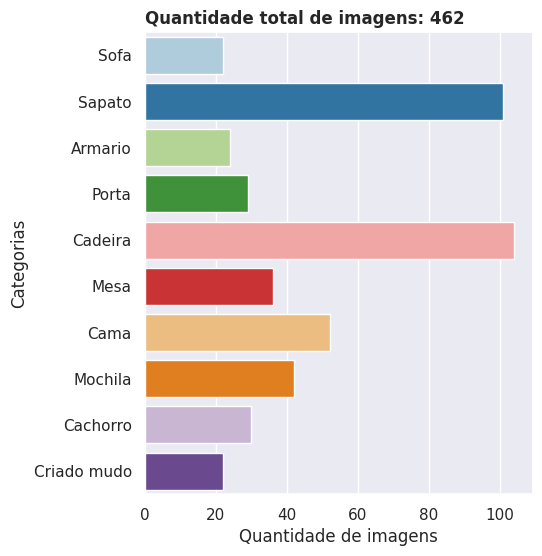

<IPython.core.display.Javascript object>

'Training metrics not found. Please check the training output for details.'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FileNotFoundError: [Errno 2] No such file or directory: '/content/yolov5/runs/train/exp/results.png'

In [118]:
render_odin()

# TESTANDO COISAS

In [ ]:
label = ipywidgets.Label(value="Dora", color = '#58d8ff')
label

In [ ]:
from ipywidgets import Button

Button(description='Danger Button', button_style='info', button_color = '#58d8ff')

In [ ]:
Button(description='Danger Button', button_style='info', button_color = '#58d8ff', font_weight = 'bold', border_radius='5px')

In [ ]:
 slider_batches = ipywidgets.IntSlider(min = 1,
                                       max = 128,
                                       step = 1,
                                       value = 16,
                                       description_tooltip='numero de lotes',
                                       description='Tamaho do batch',
                                       layout=l_hbox,
                                       style=s_desc_wid,
                                       handle_color = '#58d8ff')
 slider_batches

In [ ]:
slider_batches.style.keys

['_model_module',
 '_model_module_version',
 '_model_name',
 '_view_count',
 '_view_module',
 '_view_module_version',
 '_view_name',
 'description_width',
 'handle_color']

In [ ]:
b1.style.keys

['_model_module',
 '_model_module_version',
 '_model_name',
 '_view_count',
 '_view_module',
 '_view_module_version',
 '_view_name',
 'button_color',
 'font_weight']

In [ ]:
#progress bar
#https://medium.com/analytics-vidhya/my-gui-programming-cheatsheet-python3-jupyter-f636d5c45fcc
progress_bar_test= ipywidgets.IntProgress(value=6, min=0, max = 15, step = 1, description = 'progress', bar_style = "", orientation = 'horizontal')
progress_bar_test

IntProgress(value=6, description='progress', max=15)

In [ ]:
# testando Função para extrair metricas do output do treinamento--precisa ser ainda melhorada colocando os valores em um panda
def get_training_metrics() -> str:
  with open('/content/yolov5/training_output.txt', "r") as train_output:
    text = train_output.read()
    return text.split('Fusing layers...')[1]

print(get_training_metrics())


 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs

                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0% 0/1 [00:00<?, ?it/s]WARNING ⚠️ NMS time limit 0.700s exceeded

                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 1/1 [00:01<00:00,  1.49s/it]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 1/1 [00:01<00:00,  1.49s/it]
                   all          4          4    0.00106      0.167   0.000779   0.000234
              capivara          4          3    0.00212      0.333    0.00156   0.000467
                jacare          4          1          0          0          0          0
Results saved to runs/train/exp



In [ ]:
!python /content/yolov5/val.py --data /content/yolov5/FloripaPets-3/data.yaml --weights /content/yolov5/runs/train/exp/weights/best.pt

ValueError: ignored

In [ ]:
#testando de não deixar ele colocando output na celula
from IPython.utils import io

with io.capture_output() as captured:
  !python /content/yolov5/train.py --img 640 --batch 16 --epochs 1 --data /content/yolov5/FloripaPets-3/data.yaml --weights yolov5/yolov5n.pt

In [ ]:
#testando escrever output para arquivo
import sys

original_stdout = sys.stdout # Save a reference to the original standard output
with open('filename.txt', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    sys.stdout = !python /content/yolov5/val.py --data /content/yolov5/FloripaPets-3/data.yaml --weights /content/yolov5/runs/train/exp/weights/best.pt
    sys.stdout = original_stdout # Reset the standard output to its original value

In [ ]:
!python /content/yolov5/val.py --data /content/yolov5/FloripaPets-3/data.yaml --weights /content/yolov5/runs/train/exp/weights/best.pt | tee /content/yolov5/runs/ValidationLog.txt

val: data=/content/yolov5/FloripaPets-3/data.yaml, weights=['/content/yolov5/runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-10-g10c025d Python-3.7.15 torch-1.12.1+cu113 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
val: Scanning /content/yolov5/FloripaPets-3/valid/labels.cache... 4 images, 0 backgrounds, 0 corrupt: 100% 4/4 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0% 0/1 [00:00<?, ?it/s]WARNING ⚠️ NMS time limit 0.700s exceeded
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 1/1 [00:01<00:00,  1.38s/it]
                   all          4         

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
out = ipywidgets.Output(layout={'border': '1px solid black'})

import subprocess

@out.capture()
def function_with_captured_output():

    proc = subprocess.Popen(["python","/content/yolov5/val.py","--data ${CONFIG_YAML}","--weights /content/yolov5/runs/train/exp/weights/best.pt"], stdout=subprocess.PIPE)
    print('This goes into the output widget')
    raise Exception('As does this')

function_with_captured_output()
print('hola y dora')
pri(sys.stdout)

hola y dora


In [ ]:
import subprocess

print(subprocess.check_output(["sudo", "python", "/content/yolov5/val.py", "--data /content/yolov5/FloripaPets-3/data.yaml", "--weights /content/yolov5/runs/train/exp/weights/best.pt"], stderr=subprocess.STDOUT))




CalledProcessError: ignored

In [ ]:
sys.stdout.write('hola y dora')
sys.stdout.write('\n')
sys.stdout.write('And I am a crocodile')

In [ ]:
from time import sleep
from logging import Logger, Formatter, StreamHandler, INFO

out = ipywidgets.Output(layout={'border': '1px solid black'})
out.append_stdout('Output appended with append_stdout')
out.append_display_data("Hola soy Dora")

@out.capture()
def dora():
  print("HOLA")

display(out)

logger = Logger("testlogger")


with out:
    for i in range(10):
        logger.error("test")

Output(layout=Layout(border='1px solid black'), outputs=({'output_type': 'stream', 'name': 'stdout', 'text': '…

In [ ]:
from logging import Logger, Formatter, StreamHandler, INFO, ERROR

class MyFormatter(Formatter):
  def format(self, record):
    result = record.msg
    if record.levelno == INFO:
      result = "Dora: " + result
    else:
      result = ""
    return result

logger = Logger(__name__)

handler = StreamHandler()
handler.setLevel(INFO)

formatter = MyFormatter()
handler.setFormatter(formatter)

logger.handlers.clear()

logger.addHandler(handler)

logger.info("test")
logger.error("look")
logger.error("at")
logger.error("this")
logger.error("cool")
logger.error("script")
logger.info("test two")


Dora: test





Dora: test two
